# Markov Chain Monte Carlo - Tutorial

### By Sayeesha Sridhar

In this tutorial, we are first going to understand what is probability distribution and the Markov Chain Monte Carlo method for likelihood estimation. We will then go ahead and apply this method on a public dataset and observe the results.  

## Introduction
 Data Science is quite literally the study of data. It involves processes, methods, algorithms and techniques for capturing, processing, analyzing and deriving inferences from data. Statistics is the core of data science that provides a basis for preliminary and also in-depth analysis,  hypothesis testing and understanding data using descriptive statistics. Statistics is a key tool used to provide insights into data's structure.

__Probability distribution__  is defined as the function that maps each possible occurance of an event with its associated probability of occurance. We can also say that a probability density function (PDF) is an equation or expression that defines the spread of a continuous random variable.
Probability of occurance is in the range of 0 to 1 where 0 indicates an event has no chance of occurance and 1 means that the event will definitely occur. 

A sample space is the underlynig set of data points of all the possible values of the value under observation.


__Markov Chain Monte Carlo (MCMC) is a sampling technique/algorithm__ that is used to find the most likely estimate of a variable. 
The idea behind MCMC is that it takes large number of data points known as samples to calculate the parameters alpha and beta (in the equation below) to create an approximation of the probability. The higher the number of samples, the more accurate is the distribution generated

MCMC has 2 parts, the Markov Chain, and the Monte Carlo

__Markov Chain__ is a technique used to define the transition between states using probability. It follows the principle that probability of achieving the next state is a function of the previous state. Given a current state A, there are only small number of next states that a system can transition into. 
Let us take an example of the weather. Given that today is a bright and sunny day with an average temperature of 75 degrees Farenheit, it is easy to predict tomorrows weather with good confidence. It is impossible that there is going to be a snow storm tomorrow, given today's weather and whereas, it is very likely that tomorrow's weather will be similar to today's with a maximum of 5 degrees fluctuation. Markov Chain works on the principle that we do not need to take into account the entire history of the weather to simply predict tomorrow's weather, infact it would be very inaccurate to calculate the average of the whole year's temperate to predict tommorow's temperature. Markov's Chain says that we simple need the previous value of a variable to predict the next value, with some good confidence. 

__Monte Carlo__ is a class of computational algorithms that use infinite number of random sampling to obtain a numerical value. The concept is to use ramdomness to solve a problem that is deterministic in nature.
The most famous representation of the Monte Carlo method is in estimating the area of an irregular object. 
Use this link to understand more about Monte Carlo http://mathonweb.com/entrtain/monte/t_monte.htm


Markov Chain Monte Carlo methods are used to approximate the distribution of a parameter by using random sampling in a probabilistic space.


I understand all this may sound too vague to someone reading about MCMC for the first time, so let me go ahead and demonstrate how to apply MCMC to predict the most likely value of the stock price of Tesla. 

Note: The inspiration/reference for this tutorial has been derived from the following pages:
- https://docs.pymc.io/notebooks/getting_started.html
- https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo
- https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/
- https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
- https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50
- https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98
- https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb

The equation below highlights the probability of a stock being bought as a function of price. This is the basic sigmoid function that is also used in logistic regression

\begin{equation*}
P (stock bought|price)   = \frac{1}{1+ e^{\beta p+ \alpha}}
\end{equation*}

### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import pymc3 as pm  # the library that contains the MCMC implementation 
import scipy 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let us now import the data from the csv file named Tesla. Further:
- Filter out only the 'Low' column which indicates the lowest price paid for a stock on the given day, and the Date column. 
- We are going to be predicting the lowest price of the stock on the given day as a function of price. 
- For this particular tutorial, let us ignore the fact that the stock prediction is a time series prediction. In this tutorial for computational simplicity, we are going to predict the probability of buying a stock as a function of stock prices using the stock price of 350 days to train our model


In [2]:
data_all=pd.read_csv('Tesla.csv')
#get only the last 350 days values for simplicity 
data=data_all.tail(350)
data=data[['Date','Low']]
data=data.rename(columns={'Date':'Date','Low':'Lowest stock bought at ($)'})
data

,Date,Lowest stock bought at ($)
1342,10/27/2015,207.509995
1343,10/28/2015,208.300003
1344,10/29/2015,210.639999
1345,10/30/2015,203.889999
1346,11/2/2015,207.220001
...,...,...
1687,3/13/2017,242.779999
1688,3/14/2017,246.020004
1689,3/15/2017,254.270004
1690,3/16/2017,259.059998


In [3]:
data.describe()

,Lowest stock bought at ($)
count,350.000000
mean,214.359829
std,24.406664
min,141.050003
25%,198.482499
50%,214.934998
75%,228.044999
max,278.609985


The dataframe now has 2 columns. The minimum value of the price is 141.05 and the maximum value is 278.6

As we already know by now, data preocessing is almost always as significant as data analysis. 
So we first format this dataframe into something more suitable for the MCMC model.

The steps we follow are as follows:
- For each day in the data, create n rows where n is the value max-min (288-141 = 137. For simplicity we will take n=140)
- Create a list called offset. This will contain with values between 140 to 280 for each day. Thus each day will have 140 rows with the offset list containing integer values betweem 140 to 280 for each day. Thus this list will have (280-140)*350= 49,000   values 
- Create a list named indicator which will hold 0 for value of price_offset below the stock price of the given day and 1 for values of price_offset equal to or higher than the stock price for the given day. 

We will then zip these 3 lists to create a dataframe named df. 
The size of df will be: 350 days * 140 price offset = 49,000 enteries

In [4]:
offset=[]
dates=[]
indicator=[]
for x in data.iterrows():
    for y in range(140,280):
        i=y
        offset.append(y)
        dates.append(x[1][0])
        comp=int(x[1][1])
        if(i<comp):
            indicator.append(0)
        else:
            indicator.append(1)
df = pd.DataFrame(list(zip(dates, indicator,offset)), columns =['Date', 'indicator','price_offset'])

In [5]:
df

,Date,indicator,price_offset
0,10/27/2015,0,140
1,10/27/2015,0,141
2,10/27/2015,0,142
3,10/27/2015,0,143
4,10/27/2015,0,144
...,...,...,...
48995,3/17/2017,1,275
48996,3/17/2017,1,276
48997,3/17/2017,1,277
48998,3/17/2017,1,278


Now, let us plot the stock bought as a function of price using a scatterplot

The y axis has values Bought and Not bought and the x axis has the price.
In the code below, s indicates the thickness of a point and alpha controls the opaqueness of the points 

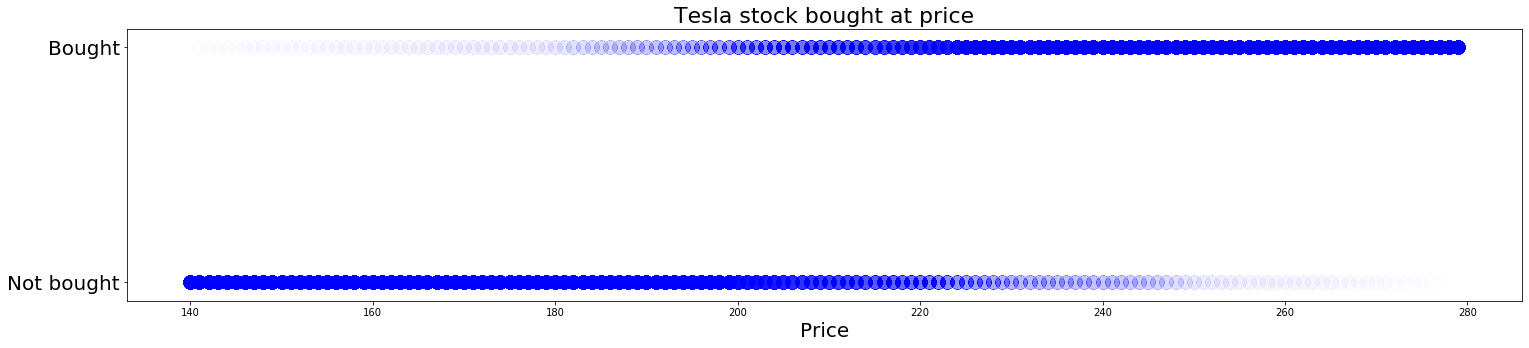

In [6]:
plt.figure(figsize=(25, 5))
plt.title('Tesla stock bought at price', size = 22)
plt.scatter(df['price_offset'], df['indicator'], s= 200, alpha=0.002, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Not bought', 'Bought'], size=20)
plt.xlabel('Price', size=20); 

We can visually scan this graph to tell that on an average, the lowest price of Tesla stock on the given days is about 210$. (We will confirm this later with our MCMC model)
Explaining the above scatter plot further:

- The more darker the blue for Not bought in the price range, the more number of days where the stock was not bought below that price. 
- And similarly for Bought, the darker blue indicates more days where the stock was bought at a price lower than the corresponding price on the x axis. 
- This graph is cumulative. A darker colour indicates that stock was bought at a price equal to or lower that the corresponding x axis and thats why we can see that all the stocks are bought below 280$

Now let us go ahead and actually plot a MCMC probability curve on this scatter plot that will give us the probability of buying a stock for each price in the given range.


Logistic regression's sigmoid function is used to model transitions from a 0 to 1. We will also be using this to represent the transition from 'Not bought' to 'Bought' of the stock price. In our model, not bought will be a 0 and bought will be a 1

The sigmoid function can be expressed as:
\begin{equation*}
P (stock bought|price)   = \frac{1}{1+ e^{\beta p + \alpha}}
\end{equation*}




Here, 𝛽 determines the slope of the sigmoid curve and 𝛼 determines the offset from 0.

The variables 𝛼 and 𝛽 is unknown an we will use MCMC to caluclate them. 
The MCMC algorithm used here is Metropolis Hastings. 

The sigmoid function below takes in the value of alpha, beta and the price and computes the equation above and returns the probability

In [7]:
# This function named sigmoid will take in values p,alpha and beta and return the result of the above equation
# Here p will be a list of values
def sigmoid(p, alpha,beta):
    prob=1.0 / (1.0 + np.exp(beta*p+alpha))
    return prob

Let us choose the number of samples for MCMC as 2000. This means that our model will draw 2000 samples for alpha and beta

In [8]:
Number_Samples = 2000

Take the price_offset column of the dataframe and load it into a numpy array called price

In [9]:
price = np.array(df.loc[:, 'price_offset'])

Take the indicator column of the dataframe and load it into a numpy array called indicators

In [10]:
indicators = np.array(df.loc[:, 'indicator'])

In this context, alpha and beta are assumed to be normally distributed with a mean of $\mu$ and a variance of $\tau$. Our model will sample values of $\mu$ and $\tau$ for $\alpha$ and $\beta$ to maximize the parameters of the sigmoid function

Now we model the data using Metropolis Hastings, a particular MCMC implementation

We will use the PyMC3 library in python for MCMC

Let us first understand what the function below does. It follows the following steps:
 - First define alpha and beta as a normally distributed variable
 - Call the sigmoid function repeatedly on the values of alpha and beta, and store the returned probability. This is done using the pm.Deterministic function that stores values of changing variables. The values of the probability returned by the sigmoid function are stored in p 
 - Get the bernoillo distribution of the price
 - Define the Metropolis Hastings method 
 - Call the pm.sample method that does the main task of drawing random samples of alpha and beta using Metropolis Hastings. The varible price_trace will store all the values of alpha and beta

In [11]:
with pm.Model() as model:
    #define alpha and beta as normally distributed variables
    alpha = pm.Normal('alpha')
    beta = pm.Normal('beta')
    
    # Create the probability from the sigmoid function
    # the pm.Deterministic is used to keep track of a variable undergoing transformation 
    p = pm.Deterministic('p', sigmoid(price,alpha,beta))
    
    # observed is a bernoilli distribution of the observed price
    # pm is the imported Pymc3 package
    observed = pm.Bernoulli('obs', p, observed=indicators)
    
    # defining the Metropolis Hastings Sampling algorithm as the step method
    step = pm.Metropolis()
    
    # The pm.sample method draws random samples 2000 times using Metropolis Hastings
    #The price_trace will contain all the 2000 values of alpha and beta
    price_trace = pm.sample(Number_Samples, step=step);


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:12<00:00, 138.40draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Great! Now we have the values of alpha and beta!

But we now have 2000 values of alpha and beta. Let us now analyze the values of alpha and beta and observe the distribution

In [12]:
alpha_samples = price_trace["alpha"]
beta_samples = price_trace["beta"]

Now lets see what are the values of alpha we have gotten from the MCMC model. We take the last 200 values of alpha and beta as they are the most accurate. MCMC starts modeling the values of alpha and beta from 0 to reach their most accurate value. Higher number of samples will give us a more accurate value of alpha and beta, but for this tutorial, for computational simplicity, we have kept the number of samples to 2000.

In [13]:
last_200_alpha_samples = alpha_samples[-200]
last_200_beta_samples = beta_samples[-200]

print("The mean value of alpha is: " + str(last_200_alpha_samples.mean()))
print("The mean value of alpha is: " + str(last_200_beta_samples.mean()))


The mean value of alpha is: 8.102635221578335
The mean value of alpha is: -0.037938410325786986


On substituting the value of alpha and beta, the equation we get that gives us the probability of purchasing a stock at a given price is:

\begin{equation*}
P (stock bought|price)   = \frac{1}{1+ e^{-0.055 p + 11.7}}
\end{equation*}


Below we plot the distribution of alpha and beta using a histogram with the number of bins set to 20. We can see that MCMC initially started with alpha and beta as 0 but then the most accurate value of alpha is about 11.7 and the most accurate value of beta is -0.055

Text(0, 0.5, 'Probability Density')

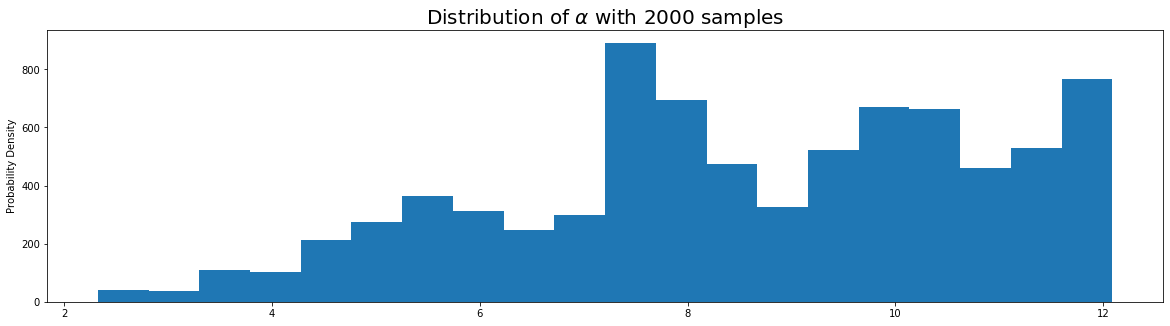

In [14]:
plt.figure(figsize=(20, 5))
plt.title(r"Distribution of $\alpha$ with 2000 samples", fontsize=20)
plt.hist(alpha_samples,bins=20);
plt.ylabel('Probability Density')

We can observe the change in alpha with each sample in the plot below:

(0, 1998)

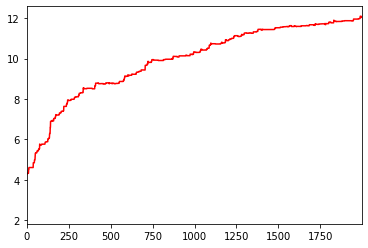

In [15]:
ax1= plt.plot(alpha_samples, color = 'red')
plt.xlim([0, 1998])

We can observe the change in beta with each sample in the plot below:

Text(0, 0.5, 'Probability Density')

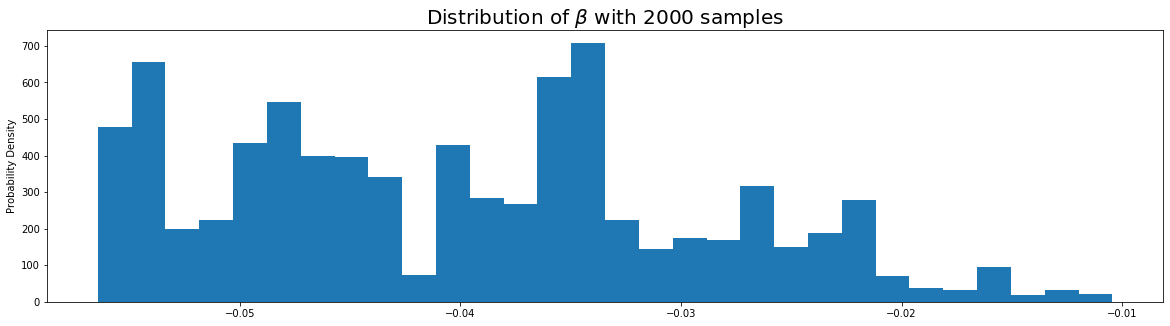

In [16]:
plt.figure(figsize=(20, 5))
plt.title(r"Distribution of $\beta$ with 2000 samples", fontsize=20)
plt.hist(beta_samples,bins=30);
plt.ylabel('Probability Density')

(0, 1998)

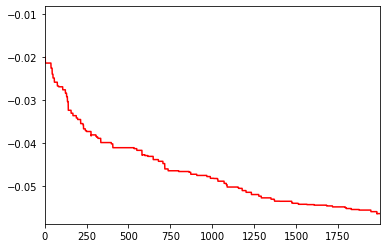

In [17]:
ax1= plt.plot(beta_samples, color = 'red')
# plt.ylim([-0.05, 0])
plt.xlim([0, 1998])


Now, as the final step, let us try to plot the probability distribution of price that we have obtained. 


The code cell below does the following things:
- create an array with values evenly spaced between 288-141, the maximum and minimum price of the stock in the given date range
- calculate the mean of the last 200 values of alpha
- calculate the mean of the last 200 values of beta
- Finally, use the above values of alpha and beta to call the sigmoid function to get the final probability distribution.

In [18]:
# Price values for probability prediction
# Returns evenly spaced numbers between min price and max price
price_estimate = np.linspace(price.min(), price.max())
alpha_estimate = last_200_alpha_samples.mean()
beta_estimate = last_200_beta_samples.mean()

# Probability of buying at each price using mean values of alpha and beta
prob_buy = sigmoid(price_estimate, alpha_estimate, beta_estimate)

As we see below, the variable prob_buy contains the probability of buying a stock for each integer price in the range 140$ - 280$

In [19]:
prob_buy

array([0.05779842, 0.06394586, 0.07069807, 0.07810378, 0.08621328,
       0.09507795, 0.10474962, 0.11527979, 0.12671869, 0.13911417,
       0.15251041, 0.16694649, 0.18245486, 0.19905962, 0.21677486,
       0.23560289, 0.25553271, 0.2765385 , 0.2985785 , 0.32159425,
       0.34551024, 0.37023414, 0.39565771, 0.42165819, 0.44810039,
       0.47483936, 0.50172338, 0.52859744, 0.55530675, 0.58170029,
       0.60763417, 0.63297468, 0.65760081, 0.68140627, 0.70430088,
       0.7262113 , 0.74708124, 0.76687103, 0.78555682, 0.8031294 ,
       0.8195927 , 0.83496216, 0.84926306, 0.86252879, 0.87479917,
       0.88611892, 0.89653627, 0.90610166, 0.9148667 , 0.92288318])

Now that we have our probability distribution, lets plot it using a scatter plot and observe.

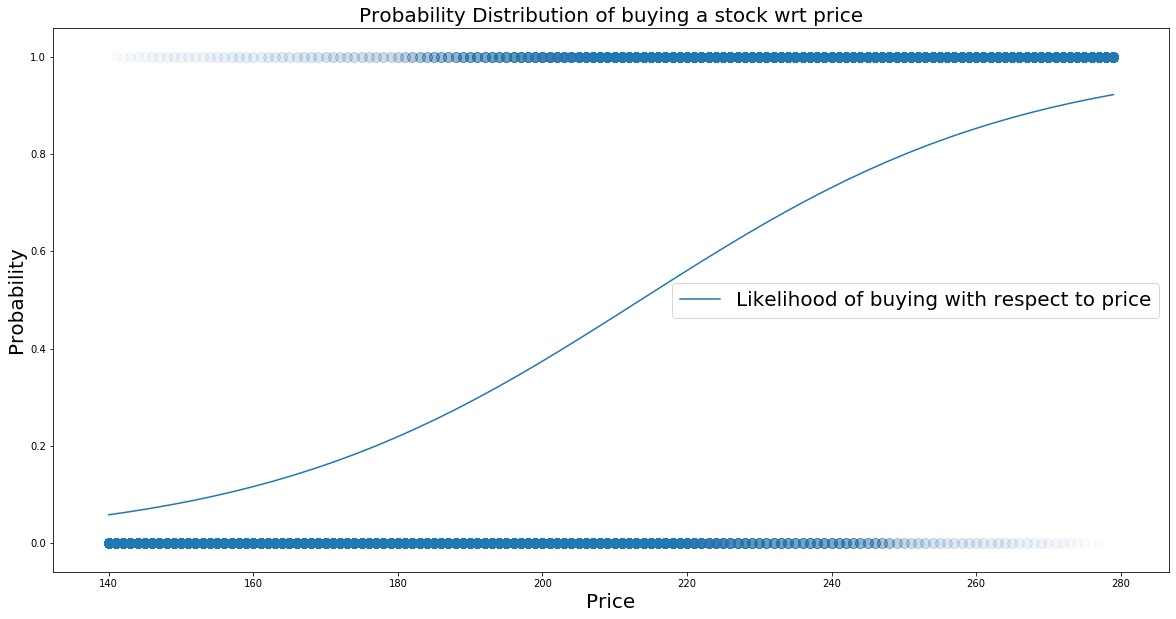

In [20]:
plt.figure(figsize=(20, 10))
plt.title('Probability Distribution of buying a stock wrt price',  fontsize=20);
plt.plot(price_estimate, prob_buy, label="Likelihood of buying with respect to price")
plt.scatter(price, indicators,s= 100, alpha=0.01) #s indicates the thickness of a point and alpha controls the opaqueness of the points 
plt.legend(["Likelihood of buying with respect to price"], fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Price', fontsize=20);

The plot above is a probability distribution of the stock price of Tesla using MCMC!
Let us now get the price below which there is an x % probability of buying a stock:

In [21]:
prob_25 = (price_estimate[np.where(prob_buy > 0.25)][0])
prob_50 = (price_estimate[np.where(prob_buy > 0.5)][0])
prob_75 = (price_estimate[np.where(prob_buy > 0.75)][0])

print("The probability of buying is 25% at " + str(prob_25))
print("The probability of buying is 50% at " + str(prob_50))
print("The probability of buying is 75% at " + str(prob_75))

The probability of buying is 25% at 185.3877551020408
The probability of buying is 50% at 213.75510204081633
The probability of buying is 75% at 244.9591836734694


We can even do the inverse of this by getting what is the probability that you can purchase a stock at the given price

In [22]:
price_150 = sigmoid(150,alpha_estimate, beta_estimate)
print("The probability of buying a Tesla stock with 150$ is " + str(100*price_150) + "%")
price_150 = sigmoid(200,alpha_estimate, beta_estimate)
print("The probability of buying a Tesla stock with 200$ is " + str(100*price_150) + "%")
price_150 = sigmoid(250,alpha_estimate, beta_estimate)
print("The probability of buying a Tesla stock with 250$ is " + str(100*price_150) + "%")


The probability of buying a Tesla stock with 150$ is 8.227173925918136%
The probability of buying a Tesla stock with 200$ is 37.40331097655774%
The probability of buying a Tesla stock with 250$ is 79.9306781013528%


#### That is the end of this tutorial. Hope you found it useful and are now clear on the working of one of statistics most advanced concepts, the Markov Chain Monte Carlo method. 